In [92]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (11, 6)
conn = sqlite3.connect('all_measures_fiction.db')
c = conn.cursor()
query_train = """SELECT metadata.doc_id as doc_id, metadata.pub_year, oed_ratio_no_set, oed_neo, gl_ratio_no_set, neo, walker_ratio_no_set 
FROM results LEFT JOIN metadata ON results.doc_id=metadata.doc_id 
WHERE test_train = 0 AND is_resample = 0"""
train_rows = c.execute(query_train).fetchall()

query_test = """SELECT metadata.doc_id as doc_id, metadata.pub_year, oed_ratio_no_set, oed_neo, gl_ratio_no_set, neo, walker_ratio_no_set 
FROM results LEFT JOIN metadata ON results.doc_id=metadata.doc_id 
WHERE test_train = 1 AND is_resample = 0"""
test_rows = c.execute(query_test).fetchall()

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


The following uses some probably dubious features to see how well they predict date. The idea isn't necessarily to use this as a classifier, but see what happens when you try to predict year based on these macro ratios instead of invidual features. In this first example, I use every individual year as a "target," meaning that the machine treats every individual year as an isolated probability. Not surprisingly, this isn't especially accurate, although the accuracy rate to 35 years and a mean error are both better than I would have thought.  

In [93]:
#3 and 5 are neo
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
target = [i[1] for i in train_rows] 
train = [[i[2], i[3], i[4], i[5], i[6]] for i in train_rows]

test = [[i[2], i[3], i[4], i[5], i[6]] for i in test_rows]
test_years = [i[1] for i in test_rows]
test_doc_ids = [i[0] for i in test_rows]

mnb = MultinomialNB()
y_pred = mnb.fit(train, target).predict(test)
pairs = tuple(zip(test_years, y_pred))
differences = [abs(i[0] - i[1]) for i in pairs]
accuracy_to_35 = len([i for i in differences if i <=35])/len(differences)
mean_error = sum(differences)/float(len(differences))
print(mean_error, accuracy_to_35)

35.4333333333 0.6111111111111112


In [94]:
from sklearn.linear_model import LinearRegression
lrg = LinearRegression()
y_pred = lrg.fit(train, target).predict(test)

pairs = tuple(zip(test_years, y_pred))
differences = [abs(i[0] - i[1]) for i in pairs]
accuracy_to_35 = len([i for i in differences if i <=35])/len(differences)
mean_error = sum(differences)/float(len(differences))
print(mean_error, accuracy_to_35)

24.6904084111 0.7777777777777778


In [95]:
gnb = GaussianNB()
y_pred = gnb.fit(train, target).predict(test)

pairs = tuple(zip(test_years, y_pred))
differences = [abs(i[0] - i[1]) for i in pairs]
accuracy_to_35 = len([i for i in differences if i <=35])/len(differences)
mean_error = sum(differences)/float(len(differences))
print(mean_error, accuracy_to_35)

28.2444444444 0.7222222222222222


In [96]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
y_pred = clf.fit(train, target).predict(test)
pairs = tuple(zip(test_years, y_pred))
differences = [abs(i[0] - i[1]) for i in pairs]
accuracy_to_35 = len([i for i in differences if i <=35])/len(differences)
mean_error = sum(differences)/float(len(differences))
print(mean_error, accuracy_to_35)

27.1 0.7222222222222222


Naive Bayes, Gaussian filter, seems to perform best of this grouping, but the decision tree classifier is also more accurate than I thought it would be. Next, I tried creating fewer categories by making year groups. 

In [97]:
def convert_to_groups(years, year_range=25):
    start = 1751
    end = 1901
    year_groups = [i for i in range(start, end, year_range)]
    results = []
    for i in years:
        for y in year_groups:
            if i >= y and i < y+year_range:
                results.append(y)
    return results 

In [98]:
mnb = MultinomialNB()
train_groups = convert_to_groups(target) 
y_pred = mnb.fit(train, train_groups).predict(test)
test_groups = convert_to_groups(test_years)
pairs = tuple(zip(test_groups, y_pred))
acc = len([i for i in pairs if i[0] == i[1]])/float(len(pairs))
print(acc)
adj = len([i for i in pairs if abs(i[0]-i[1]) <= 26])/float(len(pairs))
print(adj)

0.3
0.6444444444444445


In [99]:
gnb = GaussianNB()
y_pred = gnb.fit(train, train_groups).predict(test)
test_groups = convert_to_groups(test_years)
pairs = tuple(zip(test_groups, y_pred))
acc = len([i for i in pairs if i[0] == i[1]])/float(len(pairs))
print(acc)
adj = len([i for i in pairs if abs(i[0]-i[1]) <= 26])/float(len(pairs))
print(adj)

0.36666666666666664
0.8333333333333334


Originally, I hypothesized that these groupings would be more accurate, but I was completely wrong. With a multinomial Naive Bayes classifier, the 25-year clusters are only 21% accurate, which is just a little better than random. The Gaussian filter performs much better at 40% accuracy. Further, 80% of cases were placed either in the right group or in an adjacent group. In the next frame, I tried running the same test using only neologism ratios. 

In [100]:
train_neo = [[i[3], i[5]] for i in train_rows]
test_neo = [[i[3], i[5]] for i in test_rows]
                  
gnb = GaussianNB()
y_pred = gnb.fit(train_neo, train_groups).predict(test_neo)
test_groups = convert_to_groups(test_years)
pairs = tuple(zip(test_groups, y_pred))
acc = len([i for i in pairs if i[0] == i[1]])/float(len(pairs))
print(acc)
adj = len([i for i in pairs if abs(i[0]-i[1]) <= 26])/float(len(pairs))
print(adj)

0.25555555555555554
0.6777777777777778


In [101]:
gnb = GaussianNB()
train_groups = convert_to_groups(target, 50) 

y_pred = gnb.fit(train, train_groups).predict(test)
test_groups = convert_to_groups(test_years, 50)
pairs = tuple(zip(test_groups, y_pred))
acc = len([i for i in pairs if i[0] == i[1]])/float(len(pairs))
print(acc)
adj = len([i for i in pairs if abs(i[0]-i[1]) <= 50])/float(len(pairs))
print(adj)

0.6777777777777778
0.9444444444444444


Seems like the best adjacency rate comes from a 50-year window, which makes sense, because there are basically three categories: early, middle, and late and there's a high base probability that an item in the middle group belongs to an adjacent group, and that an item placed in a peropheral group belongs in the upper or lower group. Meanwhile, a binary classifier (pre 1826 vs post) performs at about 80 percent accuracy. (And maybe a little better with logistic regression instead of a Gaussian Naives Bayes.) I suspected that this type of classification would tend to be accurate on the edges of the data and less so in the middle, so I started thinking about how to incorporate these two methods together to do something like "ballparking" and then defining.

In [114]:
gnb = GaussianNB()

train_groups = convert_to_groups(target, 75) 
train_binary = [0 if i == 1751 else 1 for i in train_groups] 
        
y_pred = gnb.fit(train, train_binary).predict(test)
test_groups = convert_to_groups(test_years, 75)
test_binary = [0 if i == 1751 else 1 for i in test_groups]
pairs = tuple(zip(test_binary, y_pred))
acc = len([i for i in pairs if i[0] == i[1]])/float(len(pairs))
print(acc)

0.7888888888888889


In [115]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, VarianceThreshold

lr = LogisticRegression()
train_groups = convert_to_groups(target, 75) 
train_binary = [0 if i == 1751 else 1 for i in train_groups] 

s = VarianceThreshold(threshold=.08)
xnew = s.fit_transform(train, train_binary)
ynew = s.transform(test)

m= lr.fit(xnew, train_binary)
y_pred = m.predict(ynew)
probs = m.predict_proba(ynew)
test_groups = convert_to_groups(test_years, 75)
test_binary = [0 if i == 1751 else 1 for i in test_groups]
pairs = tuple(zip(test_binary, y_pred, probs.tolist()))
acc = len([i for i in pairs if i[0] == i[1]])/float(len(pairs))
print(acc)

0.8111111111111111


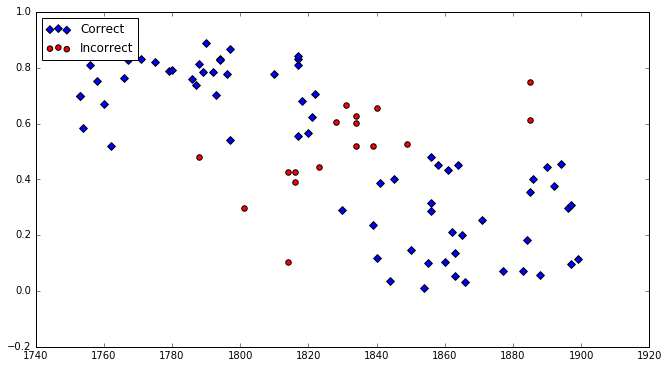

In [134]:
#plot probability vs actual
#plt.scatter()

fig = plt.figure()
ax1 = fig.add_subplot(111)
pairs = list(zip(test_binary, y_pred, test_years, [i[0] for i in probs.tolist()]))
correct = [i for i in pairs if i[0] == i[1]]
incorrect = [i for i in pairs if i[0] != i[1]]
ax1.scatter([i[2] for i in correct], [i[3] for i in correct], s=30, c='b', marker="D", label='Correct')
ax1.scatter([i[2] for i in incorrect], [i[3] for i in incorrect], s=30, c='r', marker="o", label='Incorrect')
plt.legend(loc='upper left');
plt.show()

In [13]:
tg_year_counts = Counter(train_groups)
tg_year_counts

Counter({1751: 244, 1826: 205})

In [135]:
r = list(zip([i[0] for i in pairs], [i[1] for i in pairs], test_groups))
year_counts = Counter(test_groups) 
right = Counter([i[2] for i in r if i[0] == i[1]])
acc_by_year = []
for i in year_counts.keys():
    acc = right[i]/float(year_counts[i])
    acc_by_year.append((acc, i))
acc_by_year = sorted(acc_by_year)
acc_by_year

[(0.7777777777777778, 1826), (0.8444444444444444, 1751)]

In [148]:
#bootstrapping 
#get doc ids
conn = sqlite3.connect('all_measures_fiction.db')
c = conn.cursor()
doc_ids_q = """SELECT doc_id FROM metadata"""
doc_ids = c.execute(doc_ids_q).fetchall()

query_train = """SELECT metadata.doc_id as doc_id, metadata.pub_year, oed_ratio_no_set, oed_neo, gl_ratio_no_set, neo, walker_ratio_no_set 
FROM results LEFT JOIN metadata ON results.doc_id=metadata.doc_id 
WHERE test_train = 0 AND is_resample = 1"""

query_test = """SELECT metadata.doc_id, metadata.pub_year, oed_ratio_no_set, oed_neo, gl_ratio_no_set, neo, walker_ratio_no_set 
FROM results LEFT JOIN metadata ON results.doc_id=metadata.doc_id 
WHERE test_train = 1 AND is_resample = 1 AND metadata.doc_id=?"""
#loop doc ids
train_rows = c.execute(query_train).fetchall()

target = [i[1] for i in train_rows] 
train = [[i[2], i[3], i[4], i[5], i[6]] for i in train_rows]
gnb = GaussianNB()
machine = gnb.fit(train, target)

y_pred = []
for did in doc_ids:
    #get rows for each sample, 
    
    test_rows = c.execute(query_test, did).fetchall()
    if test_rows:
        votes = []
        year = test_rows[0][1]
        doc_id = test_rows[0][0]
        for row in test_rows:
            test = [[row[2], row[3], row[4], row[5], row[6]]]
            _y = machine.predict(test)
            votes.append(int(_y))
        data = (doc_id, year, votes)
        y_pred.append(data)

In [176]:
#convert multiple predictions to one
d = zip(y_predicted, test_years)
differences = [abs(i[0] - i[1]) for i in d]

accuracy_to_35 = len([i for i in differences if i <=35])/len(differences)
mean_error = sum(differences)/float(len(differences))
print(mean_error, accuracy_to_35)

37.2666666667 0.6111111111111112


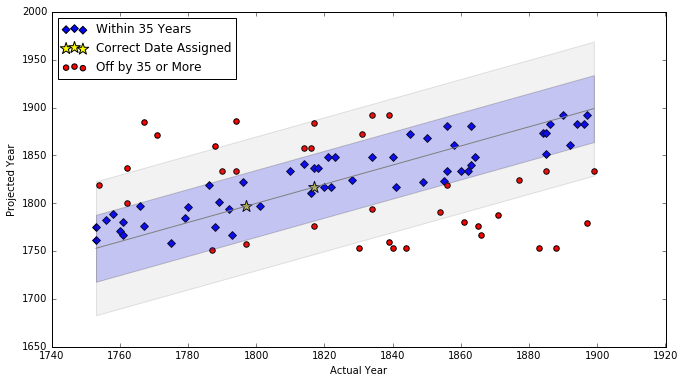

In [195]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
y_predicted = [Counter(i[2]).most_common()[0][0] for i in y_pred]
pairs = list(zip(differences, y_predicted, test_years))
pairs = sorted(pairs, key=lambda x: x[2])

correct = [i for i in pairs if i[0] == 0]
close = [i for i in pairs if i[0] != 0 and i[0] <= 35]
incorrect = [i for i in pairs if i[0] >= 35]

ax1.scatter([i[2] for i in close], [i[1] for i in close], s=30, c='b', marker="D", label='Within 35 Years')
ax1.scatter([i[2] for i in correct], [i[1] for i in correct], s=150, c='yellow', marker="*", label='Correct Date Assigned')
ax1.scatter([i[2] for i in incorrect], [i[1] for i in incorrect], s=30, c='r', marker="o", label='Off by 35 or More')
ax1.plot([i[2] for i in pairs], [i[2] for i in pairs], c="gray")
ax1.fill_between([i[2] for i in pairs], [i[2]-35 for i in pairs], [i[2]+35 for i in pairs], facecolor='blue', alpha=0.2)
ax1.fill_between([i[2] for i in pairs], [i[2]-70 for i in pairs], [i[2]+70 for i in pairs], facecolor='gray', alpha=0.1)

plt.legend(loc='upper left');
ax1.set_xlabel('Actual Year')
ax1.set_ylabel('Projected Year')
plt.show()